In [1]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import scipy.optimize
%matplotlib inline

from baseline_calculator import *
from simple_averaging_recommender import SimpleAveragingRecommender

In [2]:
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')

In [3]:
phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)

In [4]:
def X_and_y_of(df):
    return df[['user_id', 'business_id']].values, df['stars'].values

reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

X_train, y_train = X_and_y_of(reviews_train)
X_test, y_test = X_and_y_of(reviews_test)

In [8]:
def summarize_performance(model):
    name = model.__class__.__name__
    print '{} train RMSE: {}'.format(name, model.rmse(X_train, y_train))
    print '{} test RMSE: {}'.format(name, model.rmse(X_test, y_test))

In [8]:
#simple_avg = SimpleAveragingRecommender()
#simple_avg.fit(X_train, y_train)
#summarize_performance(simple_avg)

In [9]:
sabc = SimpleAverageBaselineCalculator()
sabc.fit(reviews_train)
sabc_train_rmse = sabc.baseline_rmse(reviews_train)
sabc_test_rmse = sabc.baseline_rmse(reviews_test)
print(sabc_train_rmse)
print(sabc_test_rmse)

0.976644727132
1.34699149129


In [10]:
ambc = AbsoluteMeanBaselineCalculator()
ambc.fit(reviews_train)
ambc_train_rmse = ambc.baseline_rmse(reviews_train)
ambc_test_rmse = ambc.baseline_rmse(reviews_test)
print(ambc_train_rmse)
print(ambc_test_rmse)

1.35148870051
1.35392475252


In [17]:
bpbc = BetaPriorBaselineCalculator()
bpbc.fit(reviews_train, prior_strength=8)
print(bpbc.baseline_rmse(reviews_train))
print(bpbc.baseline_rmse(reviews_test))

1.09695751608
1.22952649483


In [5]:
bpbc = BetaPriorBaselineCalculator()
prior_strs = list(np.arange(2, 50, 1)) + list(np.arange(51, 501, 25)) + list(np.arange(501, 2001, 250))
train_rmses = []
test_rmses = []
for prior_strength in prior_strs:
    bpbc.fit(reviews_train, prior_strength=prior_strength)
    train_rmses.append(bpbc.baseline_rmse(reviews_train))
    test_rmses.append(bpbc.baseline_rmse(reviews_test))

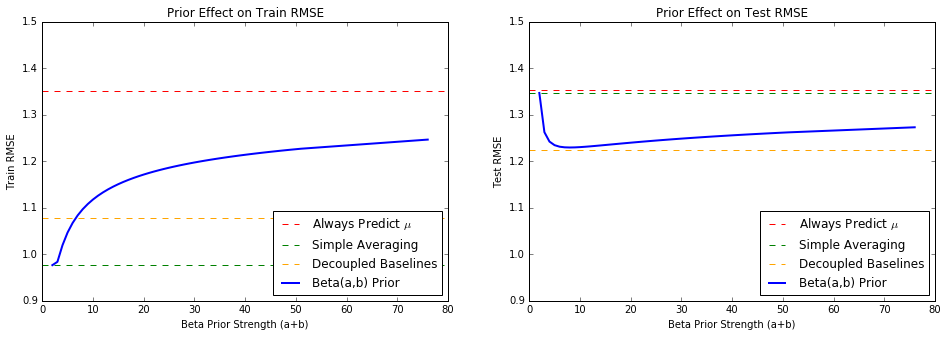

In [42]:
fig = plt.figure(figsize=(16,5))
n=50
fig.add_subplot(121)
plt.title('Prior Effect on Train RMSE')
plt.ylabel('Train RMSE')
plt.xlabel('Beta Prior Strength (a+b)')
plt.axhline(ambc_train_rmse, label=r'Always Predict $\mu$', ls='--', color='red')
plt.axhline(sabc_train_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(1.07810838094, label='Decoupled Baselines', ls='--', color='orange')
plt.plot(prior_strs[:n], train_rmses[:n], label='Beta(a,b) Prior', lw=2)
plt.ylim(0.9, 1.5)
plt.legend(loc='lower right')

fig.add_subplot(122)
plt.title('Prior Effect on Test RMSE')
plt.ylabel('Test RMSE')
plt.xlabel('Beta Prior Strength (a+b)')
plt.axhline(ambc_test_rmse, label=r'Always Predict $\mu$', ls='--', color='red')
plt.axhline(sabc_test_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(1.22479964424, label='Decoupled Baselines', ls='--', color='orange')
plt.plot(prior_strs[:n], test_rmses[:n], label='Beta(a,b) Prior', lw=2)
plt.ylim(0.9, 1.5)
plt.legend(loc='lower right')

plt.show()

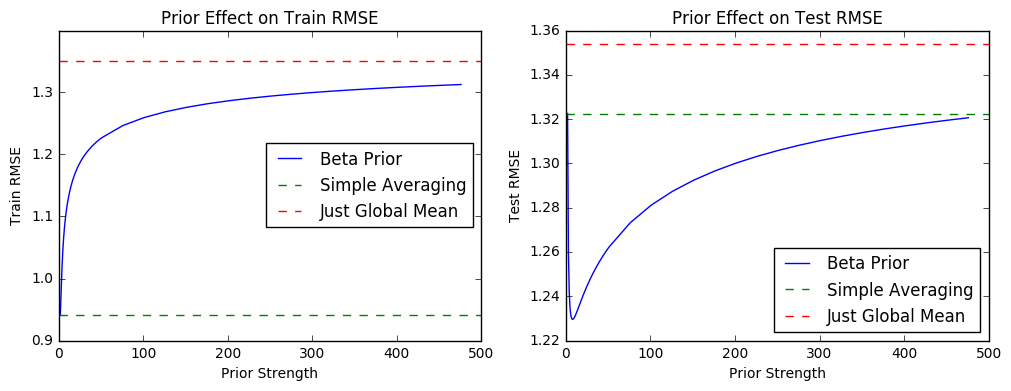

In [19]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.title('Prior Effect on Train RMSE')
plt.ylabel('Train RMSE')
plt.xlabel('Prior Strength')
plt.plot(prior_strs, train_rmses, label='Beta Prior')
plt.axhline(sabc_train_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(ambc_train_rmse, label='Just Global Mean', ls='--', color='red')
plt.legend(loc='best')

fig.add_subplot(122)
plt.title('Prior Effect on Test RMSE')
plt.ylabel('Test RMSE')
plt.xlabel('Prior Strength')
plt.plot(prior_strs, test_rmses, label='Beta Prior')
plt.axhline(sabc_test_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(ambc_test_rmse, label='Just Global Mean', ls='--', color='red')
plt.legend(loc='best')

plt.show()

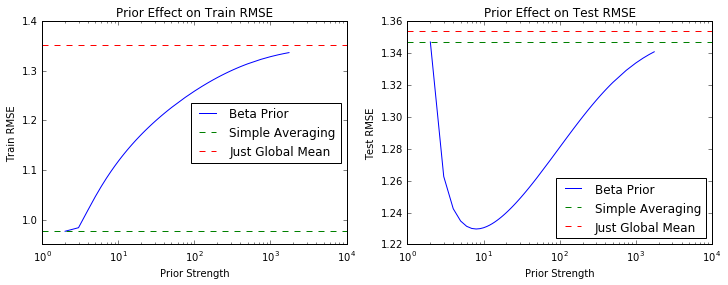

In [11]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.title('Prior Effect on Train RMSE')
plt.ylabel('Train RMSE')
plt.xlabel('Prior Strength')
plt.semilogx(prior_strs, train_rmses, label='Beta Prior')
plt.axhline(sabc_train_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(ambc_train_rmse, label='Just Global Mean', ls='--', color='red')
plt.legend(loc='best')

fig.add_subplot(122)
plt.title('Prior Effect on Test RMSE')
plt.ylabel('Test RMSE')
plt.xlabel('Prior Strength')
plt.semilogx(prior_strs, test_rmses, label='Beta Prior')
plt.axhline(sabc_test_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(ambc_test_rmse, label='Just Global Mean', ls='--', color='red')
plt.legend(loc='best')

plt.show()

In [20]:
prior_strs[np.argmin(test_rmses)]

8

In [21]:
min(test_rmses)

1.2295264948285856

First thing to note -- we actually would have gotten a lower RMSE than simple averaging had we just predicted the global mean for every restaurant. That means our baseline models were actually extremely terrible.

Second thing to note -- our beta priors make sense, because when our prior strength is minimal (at a=b=1, which describes a uniform prior), our RMSE matches simple averaging exactly, and when our prior strength $\to \infty$, it matches just predicting the global mean everywhere. This is good to note! 

In [12]:
sabc = SimpleAverageBaselineCalculator()
sabc.fit(reviews_train)
sabc.transform(reviews_train)
inv = sabc.inverse_transform(reviews_train, reviews_train.starz)
np.testing.assert_array_almost_equal(inv, reviews_train.stars)

In [23]:
joined_reviews = pd.merge(pd.merge(reviews,
    businesses, on='business_id', suffixes=('','_business')),
    users,      on='user_id', suffixes=('','_user'))